Getting started with the tip : SAM - Segment Anything Model

In [2]:
!pip install opencv-python
import cv2 as cv
from math import atan2, cos, sin, sqrt, pi
import numpy as np
from google.colab.patches import cv2_imshow

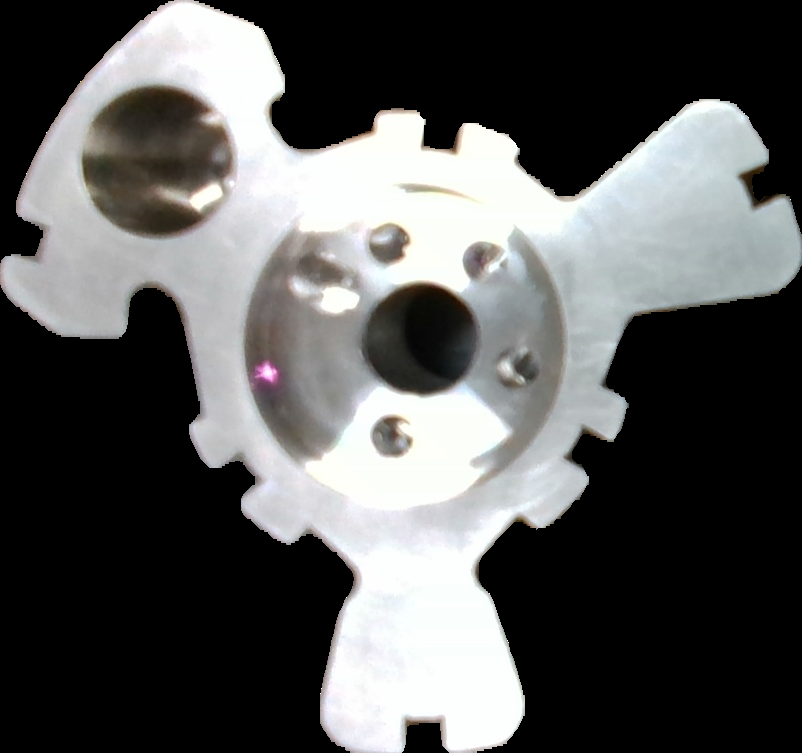

In [3]:
#mask is extracted using SAM
img = cv.imread("/content/mask_gear.png")
cv2_imshow(img)
cv.waitKey(0)
cv.destroyAllWindows()

We could have obtained the mask using Mask RCNN as well.Now that we hav obtained masks we need to focus on the techniques that identify the degree of rotation

### Approach 1 - Calculating rotation of bounding box using the mask generated - Horizontal or vertical axes aligned images

When dealing with images where objects are typically aligned vertically or horizontally, we can use **axis-aligned bounding boxes** to describe those objects. These bounding boxes align with the image axes (either horizontal or vertical), making them simpler to work with.

To achieve inetrsection of bounding boxes, we'll use a technique called **sequential cutting**. Here's how it works:

1. Start with an initial polygon defined by one of the boxes (the "box under comparison").
2. For each edge of this polygon, check if it intersects with any edges from the second box (also under comparison).
3. If there's an intersection, keep the vertices where the edges intersect and form new edges.
4. Repeat step 2 with the new edges until no more edges remain.

The pseudocode for sequential cutting looks something like this:

function sequential_cutting(box1, box2):
    # Initialize the initial polygon with vertices from box1
    polygon = box1.vertices
    
    # For each edge in the polygon
    for edge in polygon.edges:
        # Check for intersections with edges from box2
        for other_edge in box2.edges:
            if intersect(edge, other_edge):
                # Keep the intersection vertices and form new edges
                new_vertices = compute_intersection_vertices(edge, other_edge)
                polygon.add_vertices(new_vertices)
    
    # Repeat until no more intersections are found
    while intersections_exist(polygon, box2):
        # Update the polygon by checking for new intersections
        # and adding vertices as needed
    
    # Calculate the area of the resulting polygon
    iou = calculate_iou(polygon, box2)
    return iou



1. **Intersection over Union (IoU)**: This metric quantifies the overlap between two bounding boxes. To calculate it:
   - First, find the area of the polygon formed by the intersection of the two boxes (which you mentioned as "polygonal area").
   - Next, divide this intersection area by the union of the areas of both boxes.

2. **Recursive Method**: Unlike the simpler axis-aligned method, this approach considers more complex cases. It involves recursively checking for intersections between edges of the two boxes. Although more intricate, it's computationally efficient and avoids the need to rasterize boxes and anchors.

3. **Importance in Deep Neural Networks (DNNs)**:
   - During training, IoU helps measure loss.
   - During inference, it's crucial for non-maximum suppression (NMS) to select the best bounding boxes.
   - Speed matters, so the IoU calculation function should be optimized for efficiency.



### Approach 2 - Rotation calculation for misaligned images - Using Nvidia object determination toolkit(obtk)

To implement NVIDIA's Object Detection Toolkit (ODTK) for detecting object rotation in two images using rotated bounding boxes, follow these steps:

1. **Clone the Repository**:
   ```bash
   git clone https://github.com/NVIDIA/retinanet-examples
   cd retinanet-examples
   ```

2. **Build the Docker Image**:
   ```bash
   docker build -t odtk:latest .
   ```

3. **Run the Docker Container**:
   ```bash
   docker run --gpus all --rm --ipc=host -it odtk:latest
   ```

4. **Prepare the Dataset**:
   Ensure your dataset annotations are in COCO format and include the `theta` parameter for rotation. The bounding box format should be `[x, y, w, h, theta]`.

5. **Train the Model**:
   Train your model using the provided script, specifying the `--rotated-bbox` option:
   ```bash
   odtk train --backbone ResNet50FPN --images /path/to/images --annotations /path/to/annotations --val-images /path/to/val_images --val-annotations /path/to/val_annotations --rotated-bbox
   ```

6. **Perform Inference**:
   Run inference on your images, again using the `--rotated-bbox` option:
   ```bash
   odtk infer --images /path/to/test_images --output /path/to/output --rotated-bbox
   ```

7. **Analyze Results**:
   Compare the rotated bounding boxes in the two images to determine the object's rotation.



### Approach 3: Use Deep learning models and homography

To address the problem of detecting the rotation of an object between a template image and a test image, especially when the object is reflective and blurry, you can use pre-trained models designed for robust feature extraction and matching. Here are a few approaches and models one can use:

1. **Deep Learning Models**:
   - **Feature Extraction**:
     - **VGG16/VGG19**: Pre-trained on ImageNet, these models can be fine-tuned to extract features from images.
     - **ResNet50/ResNet101**: More robust feature extraction, suitable for blurry and reflective objects.
     - **SIFT/ORB**: Traditional feature extraction methods can still be effective when combined with deep learning features.

2. **Object Detection Models**:
   - **Faster R-CNN**: This model can be trained to detect objects and provide bounding boxes, which can help in locating the object in both images.
   - **YOLOv5**: Known for its speed and accuracy, it can detect objects in real-time and help in locating the object in both images.

3. **Homography Estimation Models**:
   - **SuperPoint**: A deep learning-based interest point detector that can handle challenging conditions like blur and reflections.
   - **SuperGlue**: Matches keypoints from SuperPoint for robust feature matching and homography estimation.

### Implementation Steps:

1. **Feature Extraction and Matching**:
   - Use models like VGG, ResNet, or SuperPoint to extract features from both template and test images.
   - Match the features using SuperGlue or traditional methods like FLANN-based matcher.

2. **Homography Estimation**:
   - Use the matched features to estimate the homography matrix using RANSAC.
   - Decompose the homography matrix to extract the rotation component.

3. **Rotation Calculation**:
   - Calculate the rotation angle from the homography matrix.
   - Visualize the results by drawing the bounding boxes and keypoints.


